In [5]:
%load_ext autoreload
%autoreload

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt

from constants import INPUT_SHAPE
from conversion import read_room2class, get_class2color, FloorplanRaw, FloorplanSVG, read_room2class_condensed

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
# Mappings for dataset
room2class = read_room2class_condensed("room_types_succinct.txt")
class2room = {v: k for k, v in room2class.items()}
class2color = get_class2color(max(room2class.values()))

n_classes = max(room2class.values())+1

# Semantic Segmentation Model

In [7]:
# Build model

# model = Sequential()

# n_filters = 64
# # Add network layers
# model.add(Conv2D(n_filters, (3, 3), activation='relu', padding='same', input_shape=INPUT_SHAPE))
# model.add(Conv2D(n_filters, (3, 3), activation='relu', padding='same'))
# model.add(MaxPooling2D((2, 2)))
# model.add(Conv2D(n_filters*2, (3, 3), activation='relu', padding='same'))
# model.add(Conv2D(n_filters*2, (3, 3), activation='relu', padding='same'))
# model.add(MaxPooling2D((2, 2)))
# model.add(Dropout(0.2))


# model.add(Conv2D(n_filters, (3, 3), activation='relu', padding='same'))
# model.add(Conv2DTranspose(32,(5,5),padding='same', activation=tf.nn.leaky_relu, strides=(2, 2)))
# model.add(Conv2DTranspose(16,(5,5),padding='same', activation=tf.nn.leaky_relu, strides=(2, 2)))
# model.add(Conv2DTranspose(n_classes,(5,5),padding='same', activation=tf.nn.softmax))


# # compile model
# opt = Adam(lr=0.001)
# loss = tf.keras.losses.categorical_crossentropy
# model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

# model.summary()


# Simple model for testing
model = Sequential()
model.add(Conv2D(8, (3, 3), padding='same', activation='relu', input_shape=INPUT_SHAPE))

model.add(Conv2D(16, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(Conv2DTranspose(64, (3, 3), padding='same', activation='relu', strides=(2, 2)))
model.add(Conv2DTranspose(64, (3, 3), padding='same', activation='relu', strides=(2, 2)))
model.add(Dropout(0.5))
model.add(Conv2DTranspose(64, (3, 3), padding='same', activation='relu', strides=(2, 2)))
model.add(Conv2D(n_classes, (3, 3), padding='same', activation=tf.nn.softmax))

opt = Adam(lr=0.001)
loss = tf.keras.losses.categorical_crossentropy
model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 256, 256, 8)       224       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 256, 256, 16)      1168      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 128, 128, 32)      4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 64, 64, 32)       

# Train

In [8]:
dataset_dir = "./data/cubicasa5k"
batch_size = 64

def plot_training_history(history):
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    epochs = range(1,len(accuracy)+1)

    plt.figure()
    plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
    plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()

## Train by Generator

In [5]:
# Build data generators

# def generator(dataset_dir, txt_name, room2class, batch_size, mode="train"):
#     """Generator for training data
#     """
#     dataset_txt = dataset_dir + txt_name
#     f = open(dataset_txt, "r")
#     while True:
#         inputs = []
#         labels = []
#         while len(inputs) < batch_size:
            
#             # Read next line, back from beginning if reaching end
#             line = f.readline().strip()
#             if not line:
#                 f.seek(0)
#                 line = f.readline().strip()
                
#                 #TODO: if mode is eval, do not seek to 0
            
#             # Get our converted data
#             data_folder = dataset_dir + line
#             raw = FloorplanRaw(data_folder)
#             svg = FloorplanSVG(data_folder, raw.original_shape, room2class)
            
#             inputs.append(raw.image)
#             labels.append(svg.semantic_map)
        
#         inputs = np.array(inputs)
#         labels = to_categorical(np.array(labels), num_classes=n_classes)
#         yield inputs, labels


# train_gen = generator(dataset_dir, "/train.txt", room2class, batch_size)
# val_gen = generator(dataset_dir, "/val.txt", room2class, batch_size)


def generator_from_processed(dataset_dir, txt_name, batch_size, mode="train"):
    """Generator for training data
    """
    dataset_txt = dataset_dir + txt_name
    f = open(dataset_txt, "r")
    while True:
        inputs = []
        labels = []
        while len(inputs) < batch_size:
            
            # Read next line, back from beginning if reaching end
            line = f.readline().strip()
            if not line:
                f.seek(0)
                line = f.readline().strip()
                
                #TODO: if mode is eval, do not seek to 0
            
            # Get our converted data
            data_folder = dataset_dir + line
            input_data = np.load(data_folder+"input.npy")
            label_data = np.load(data_folder+"label.npy")
            
            inputs.append(input_data)
            labels.append(label_data)
        
        inputs = np.array(inputs)
        labels = to_categorical(np.array(labels), num_classes=n_classes)
        yield inputs, labels
        

train_dir = dataset_dir + "/train"
train_gen = generator_from_processed(train_dir, "/train.txt", batch_size)

val_dir = dataset_dir + "/val"
val_gen = generator_from_processed(val_dir, "/val.txt", batch_size)

In [ ]:
%%time
# Train
num_train_images = len(open(dataset_dir + "/train/train.txt", "r").readlines())
steps_per_epoch = num_train_images // batch_size // 60
num_val_images = len(open(dataset_dir + "/val/val.txt", "r").readlines())
validation_steps = num_val_images // batch_size // 2
num_epochs = 1
verbose = 1

history = model.fit_generator(train_gen,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=val_gen,
                    validation_steps=validation_steps,
                    epochs=num_epochs,
                    verbose=verbose)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1 steps, validate for 3 steps


In [22]:
for i in range(validation_steps):
    print(i)
    a, b = next(val_gen)

0
1
2


In [24]:
b.shape

(64, 256, 256, 70)

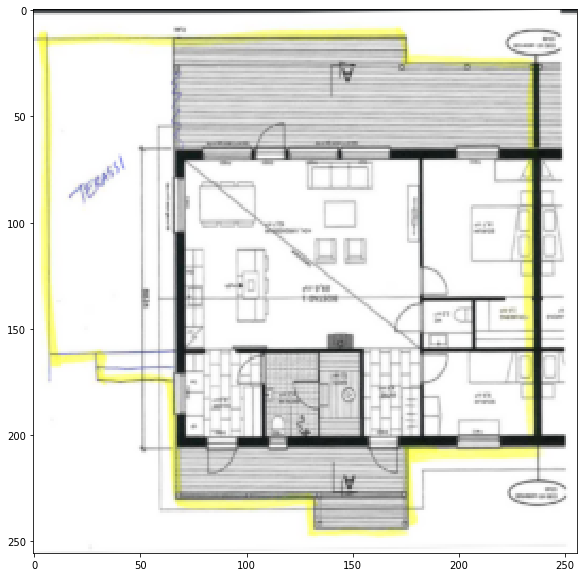

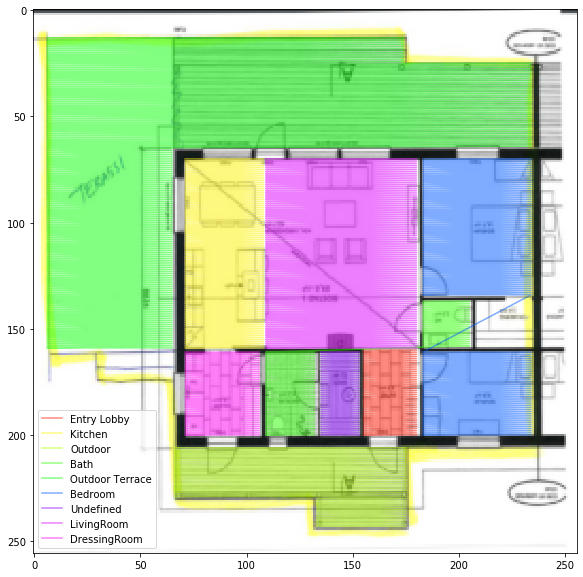

In [23]:
plt.figure(figsize = (10, 10))
plt.imshow(a[0])
result = np.argmax(b[0], axis=-1)
FloorplanSVG.show_map(result, a[0], class2color, class2room)

In [1]:
# Plot history
plot_training_history(history)

NameError: name 'plot_training_history' is not defined

In [ ]:
FloorplanSVG(trial_folder, raw.original_shape, room2class).show(0*np.ones_like(input_img), class2color, class2room)

## Train by Numpy Array

In [11]:
# Load data
train_X = np.load(dataset_dir + "/train_inputs.npy")
train_y = np.load(dataset_dir + "/train_labels.npy")
train_y = to_categorical(train_y, num_classes=n_classes, dtype=np.int8)

In [15]:
val_X = np.load(dataset_dir + "/val_inputs.npy")
val_y = np.load(dataset_dir + "/val_labels.npy")
val_y = to_categorical(val_y, num_classes=n_classes, dtype=np.int8)

In [ ]:
%%time
# Train
num_train_images = len(open(dataset_dir + "/train.txt", "r").readlines())
steps_per_epoch = num_train_images // batch_size
num_val_images = len(open(dataset_dir + "/val.txt", "r").readlines())
validation_steps = num_val_images // batch_size // 4
num_epochs = 5
verbose = 1

history = model.fit(train_X,
                    train_y,
                    batch_size=batch_size,
                    epochs=num_epochs,
                    verbose=verbose,
                    validation_data=(val_X, val_y))

Train on 825 samples, validate on 400 samples
Epoch 1/5
825/825 [==============================] - 120s 145ms/sample - loss: 1.6666 - accuracy: 0.5066 - val_loss: 1.6776 - val_accuracy: 0.4941
Epoch 2/5
825/825 [==============================] - 119s 145ms/sample - loss: 1.5979 - accuracy: 0.5066 - val_loss: 1.6346 - val_accuracy: 0.4941
Epoch 3/5
192/825 [=====>........................] - ETA: 1:17 - loss: 1.5392 - accuracy: 0.5048

In [ ]:
def generator_to_categorical(X, y, batch_size, num_classes, mode="train"):
    while True:
        idx = 0
        while idx < len(X):
            yield X[idx:idx+batch_size], to_categorical(y[idx:idx+batch_size], num_classes=num_classes)
            idx += batch_size
        
train_gen = generator_to_categorical(train_X, train_y, batch_size, n_classes)
val_gen = generator_to_categorical(val_X, val_y, batch_size, n_classes)

In [16]:
%%time
# Train
num_train_images = len(open(dataset_dir + "/train.txt", "r").readlines())
steps_per_epoch = num_train_images // batch_size
num_val_images = len(open(dataset_dir + "/val.txt", "r").readlines())
validation_steps = num_val_images // batch_size
num_epochs = 1
verbose = 1

history = model.fit_generator(train_gen,
                        steps_per_epoch=steps_per_epoch,
                        validation_data=val_gen,
                        validation_steps=validation_steps,
                        epochs=num_epochs,
                        verbose=verbose)

NameError: name 'train_gen' is not defined

In [ ]:
# Plot history
plot_training_history(history)

## Examine Results

In [25]:
model.predict(np.expand_dims(input_img, axis=0))[0, 100, 100]

array([0.280488  , 0.08161485, 0.07894681, 0.06367514, 0.08583062,
       0.13060795, 0.12067038, 0.15816627], dtype=float32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
No handles with labels found to put in legend.


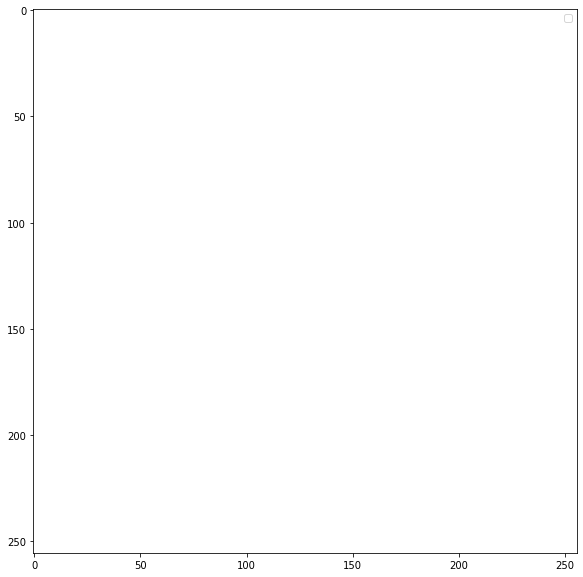

In [19]:
# Try model on an example
trial_folder = dataset_dir + "/colorful/3720/"
raw = FloorplanRaw(trial_folder)
input_img = raw.image
result = np.argmax(model.predict(np.expand_dims(input_img, axis=0)), axis=-1)[0]
FloorplanSVG.show_map(result, 255*np.ones_like(input_img), class2color, class2room)

# Groundtruth Display

In [ ]:
# Display a pair of groundtruths
trial_folder = dataset_dir + "/colorful/6327/"
raw = FloorplanRaw(trial_folder)
raw.show()
input_img = raw.image
svg = FloorplanSVG(trial_folder, raw.original_shape, room2class)
svg.show(input_img, class2color, class2room)